In [1]:
import sys
sys.path.append("../model/")
# sys.path.append("../../loss/")


In [2]:
pwd

'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/Experiments_LJH'

## test

In [3]:
import os
import cv2
import json
import math
import random
import imageio
import numpy as np
import nibabel as nib
import albumentations
import shutil
import re

from glob import glob
from tqdm import tqdm
from unet_official import UNet
from matplotlib import pyplot as plt
from dice_score import multiclass_dice_coeff, dice_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# from torchsummary import summary
from datetime import datetime

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

from skimage.filters import median
from skimage.morphology import disk

In [4]:
def seed_all(seed=42):
    print("Using Seed Number {}".format(seed))

    os.environ["PYTHONHASHSEED"] = str(seed)  # set PYTHONHASHSEED env var at fixed value
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    random.seed(seed)  # set fixed value for python built-in pseudo-random generator
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

def seed_worker(_worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
seed_all()

Using Seed Number 42


In [5]:
def is_cache(filename):
    return filename == '.ipynb_checkpoints'

def del_cache(file_list):
    if '.ipynb_checkpoints' in file_list:
        file_list.remove('.ipynb_checkpoints')
    if '@eaDir' in file_list:
        file_list.remove('@eaDir')
    return file_list

## Load train image/mask 

In [6]:
pwd

'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/Experiments_LJH'

In [7]:
p = '../data/labeling'
p_list = del_cache(os.listdir(p))
print(p_list)

['0', '1', '2']


In [8]:
'''
inputs = []
targets = []

root_path = "../data/labeling"
curation_list = del_cache(os.listdir(root_path))
patient_dict = {}

for curation in curation_list:
    patient_list = del_cache(os.listdir(f'{root_path}/{curation}'))
    patient_dict[curation] = patient_list

n = 0

for curation, patient_list in patient_dict.items():
    for patient_count, patient in enumerate(patient_list):
        # 중증도별 image의 수를 맞추어주기 위해서 조건 걸어주기
        # 한 번 돌려보고 모두 다 넣어서 학습 시켜보기
        print(patient)
        if patient_count == 8:
            break
        
        laterality_list = del_cache(os.listdir(f'{root_path}/{curation}/{patient}'))

        for laterality in laterality_list:
            image_path_list = sorted([path for path in glob(f'{root_path}/{curation}/{patient}/{laterality}/train/image/*.png')])
            mask_path_list = sorted([path for path in glob(f'{root_path}/{curation}/{patient}/{laterality}/train/mask/*.png')])

            inputs += image_path_list
            targets += mask_path_list
            
            n += len(image_path_list)
    print(f'curation: {curation}, count: {n}')
    n = 0
    '''

'\ninputs = []\ntargets = []\n\nroot_path = "../data/labeling"\ncuration_list = del_cache(os.listdir(root_path))\npatient_dict = {}\n\nfor curation in curation_list:\n    patient_list = del_cache(os.listdir(f\'{root_path}/{curation}\'))\n    patient_dict[curation] = patient_list\n\nn = 0\n\nfor curation, patient_list in patient_dict.items():\n    for patient_count, patient in enumerate(patient_list):\n        # 중증도별 image의 수를 맞추어주기 위해서 조건 걸어주기\n        # 한 번 돌려보고 모두 다 넣어서 학습 시켜보기\n        print(patient)\n        if patient_count == 8:\n            break\n        \n        laterality_list = del_cache(os.listdir(f\'{root_path}/{curation}/{patient}\'))\n\n        for laterality in laterality_list:\n            image_path_list = sorted([path for path in glob(f\'{root_path}/{curation}/{patient}/{laterality}/train/image/*.png\')])\n            mask_path_list = sorted([path for path in glob(f\'{root_path}/{curation}/{patient}/{laterality}/train/mask/*.png\')])\n\n            inputs += image_p

In [9]:
'''
## origin file images 수 확인
inputs = []
targets = []

root_path = "../data/origin"
curation_list = del_cache(os.listdir(root_path))
patient_dict = {}

for curation in curation_list:
    patient_list = del_cache(os.listdir(f'{root_path}/{curation}'))
    patient_dict[curation] = patient_list

n = 0

for curation, patient_list in patient_dict.items():
    for patient_count, patient in enumerate(patient_list):
        # if patient_count == 8:
        #     break
        
        laterality_list = del_cache(os.listdir(f'{root_path}/{curation}/{patient}'))

        for laterality in laterality_list:
            image_path_list = sorted([path for path in glob(f'{root_path}/{curation}/{patient}/{laterality}/*.png')])
            mask_path_list = sorted([path for path in glob(f'{root_path}/{curation}/{patient}/{laterality}/*.png')])

            inputs += image_path_list
            targets += mask_path_list
            
            n += len(image_path_list)
    print(f'curation: {curation}, count: {n}')
    n = 0
'''

curation: 0, count: 208
curation: 1, count: 2561
curation: 2, count: 1560
curation: 3, count: 2041
curation: 4, count: 377
curation: 5, count: 1482


In [9]:
patient_dict

{'0': ['19573425',
  '33807410',
  '35348102',
  '37416296',
  '38029099',
  '46620486',
  '50784327',
  '56061293',
  '57384540'],
 '1': ['10554838',
  '10909546',
  '11942469',
  '12282735',
  '12589474',
  '12597273',
  '13516501',
  '14965810',
  '15495578',
  '15598129',
  '15805067',
  '15863746',
  '15934299',
  '16603853',
  '16715996',
  '17394594',
  '17730208',
  '18609244'],
 '2': ['10730618',
  '10927258',
  '11852162',
  '14419432',
  '15295800',
  '15711782',
  '16323791',
  '17233839']}

In [10]:
inputs

['../data/labeling/0/19573425/OD/train/image/05.png',
 '../data/labeling/0/19573425/OD/train/image/06.png',
 '../data/labeling/0/19573425/OD/train/image/07.png',
 '../data/labeling/0/19573425/OD/train/image/08.png',
 '../data/labeling/0/19573425/OD/train/image/09.png',
 '../data/labeling/0/19573425/OD/train/image/10.png',
 '../data/labeling/0/19573425/OD/train/image/11.png',
 '../data/labeling/0/19573425/OD/train/image/12.png',
 '../data/labeling/0/19573425/OD/train/image/13.png',
 '../data/labeling/0/19573425/OD/train/image/14.png',
 '../data/labeling/0/19573425/OD/train/image/15.png',
 '../data/labeling/0/19573425/OD/train/image/16.png',
 '../data/labeling/0/19573425/OD/train/image/17.png',
 '../data/labeling/0/19573425/OS/train/image/05.png',
 '../data/labeling/0/19573425/OS/train/image/06.png',
 '../data/labeling/0/19573425/OS/train/image/07.png',
 '../data/labeling/0/19573425/OS/train/image/08.png',
 '../data/labeling/0/19573425/OS/train/image/09.png',
 '../data/labeling/0/1957342

In [8]:
dataset = list(zip(inputs, targets))
random.shuffle(dataset)
inputs, targets = zip(*dataset)

# 간단하게 확인
print(inputs[:2])
print(targets[:2])

NameError: name 'inputs' is not defined

## device 정의

In [7]:
GPU_NUM = 0
os.environ["CUDA_VISIBLE_DEVICES"]='1'
print('gpu? ', torch.cuda.is_available())
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print('Current gpu: ', torch.cuda.current_device())

if device.type == 'cuda':
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')
  

gpu?  True
Current gpu:  0
Allocated: 0.0 GB
Cached:    0.0 GB


/home/crop2292/anaconda3/envs/hoon/lib/python3.6/site-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [8]:
device

device(type='cuda', index=0)

## Dataset & DataLoader

In [9]:
def get_patches(img, mask, overlap=0.0, patch_size=256):
    h, w = np.shape(img)
    
    img_patch_list = []
    mask_patch_list = []
    
    patch_num = math.ceil((w - h) / (h * (1 - overlap))) + 1
    
    for w_start_idx in np.linspace(0, w-h, patch_num):
        w_start_idx = int(w_start_idx)
        img_patch = img[:, w_start_idx:w_start_idx+h]
        mask_patch = mask[:, w_start_idx:w_start_idx+h]
        
        X_per = patch_size / h
        resized_img = cv2.resize(img_patch, dsize=(0, 0), fx=X_per, fy=X_per, interpolation=cv2.INTER_NEAREST)
        img_patch_list.append(resized_img)
        
        resized_mask = cv2.resize(mask_patch, dsize=(0, 0), fx=X_per, fy=X_per, interpolation=cv2.INTER_NEAREST)
        mask_patch_list.append(resized_mask)
        
    return img_patch_list, mask_patch_list

In [10]:
def remove_artifact(img, mask, filter_size=(1, 5), overlap=0.4, threshold = 25):
    MEAN_VALUE = 127.5
    removed_img = img.copy()
    
    mask_h, mask_w = mask.shape
    filter_h, filter_w = filter_size[0], filter_size[1]
    
    patch_num = math.ceil((mask_w - filter_w) / (filter_w * (1 - overlap))) + 1
    
    for h_start_idx in range(0, mask_h, filter_h):
        for w_start_idx in np.linspace(0, mask_w-filter_w, patch_num):
            w_start_idx = int(w_start_idx)
            mask_region = mask[h_start_idx:h_start_idx+filter_h, w_start_idx:w_start_idx+filter_w]
            mask_region_unique_value = np.unique(mask_region)
            
            if 0 in mask_region_unique_value or 10 in mask_region_unique_value:
                continue
            
            img_region = removed_img[h_start_idx:h_start_idx+filter_h, w_start_idx:w_start_idx+filter_w]
            
            for h in range(filter_h):
                pixel_list = img_region[h, :]
                mean_pixel = int(np.mean(pixel_list))
                
                less = [element for element in pixel_list if element < mean_pixel] + [mean_pixel]
                greater = [element for element in pixel_list if element > mean_pixel] + [mean_pixel]

                for idx, element in enumerate(pixel_list): 
                    # 대체적으로 밝다
                    if mean_pixel > MEAN_VALUE and element - mean_pixel <= -threshold:
                        pixel_list[idx] = random.choice(greater)
                    # 대체적으로 어둡다
                    elif mean_pixel < MEAN_VALUE and element - mean_pixel >= threshold:
                        pixel_list[idx] = random.choice(less)      
    return removed_img

In [11]:
def remove_artifact(img, mask, name, threshold=2):
    removed_img = img.copy()
    
    # 배경과 맥랙막을 제외한 망막 layer들
    for label_num in range(1, 10):
        mask_region = mask == label_num
        
        if len(mask_region) == 0:
            print(f'{label_num} >>> {name}')
        img_region = removed_img[mask_region]
        
        mean = np.mean(img_region)
        std = np.std(img_region)
        
        outlier = [] 
        normal = []
        
        for pixel in img_region:
            z_score = abs(pixel - mean) / std 

            if z_score > threshold: 
                outlier.append(pixel)
            else:
                normal.append(pixel)

        for idx, pixel in enumerate(img_region):
            if pixel in outlier:
                img_region[idx] = random.choice(normal)
                
        removed_img[mask_region] = img_region
        
    return removed_img

In [12]:
pwd

'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/Experiments_LJH'

In [13]:
train_image_path = '../data/train_data/V2/train/image/*.png' 
train_mask_path = '../data/train_data/V2/train/mask/*.png' 

valid_image_path = '../data/train_data/V2/valid/image/*.png' 
valid_mask_path = '../data/train_data/V2/valid/mask/*.png' 

test_image_path = '../data/train_data/V2/test/image/*.png' 
test_mask_path = '../data/train_data/V2/test/mask/*.png' 

In [14]:
b = glob(train_image_path)
c = glob(train_mask_path)

for a, b in zip(b, c):
    print(a,b)
    img = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
    ma = cv2.imread(b, cv2.IMREAD_GRAYSCALE)


../data/train_data/V2/train/image/19573425_OD_05.png ../data/train_data/V2/train/mask/19573425_OD_05.png
../data/train_data/V2/train/image/19573425_OD_06.png ../data/train_data/V2/train/mask/19573425_OD_06.png
../data/train_data/V2/train/image/19573425_OD_07.png ../data/train_data/V2/train/mask/19573425_OD_07.png
../data/train_data/V2/train/image/19573425_OD_08.png ../data/train_data/V2/train/mask/19573425_OD_08.png
../data/train_data/V2/train/image/19573425_OD_09.png ../data/train_data/V2/train/mask/19573425_OD_09.png
../data/train_data/V2/train/image/19573425_OD_10.png ../data/train_data/V2/train/mask/19573425_OD_10.png
../data/train_data/V2/train/image/19573425_OD_11.png ../data/train_data/V2/train/mask/19573425_OD_11.png
../data/train_data/V2/train/image/19573425_OD_12.png ../data/train_data/V2/train/mask/19573425_OD_12.png
../data/train_data/V2/train/image/19573425_OD_13.png ../data/train_data/V2/train/mask/19573425_OD_13.png
../data/train_data/V2/train/image/19573425_OD_14.png ..

In [16]:
len(b)

51

In [15]:
class OCT_Dataset(Dataset):
    def __init__(self, image_path, mask_path, transform_with_mask=None):
        self.image_path_list = sorted(glob(image_path))
        self.mask_path_list = sorted(glob(mask_path))
        
        self.image_list = []
        self.mask_list = []
        
        self.transform_with_mask = transform_with_mask
        
        
        for (image_path, mask_path) in zip(self.image_path_list, self.mask_path_list):
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            '''
            # RAA
            image = median(image, disk(1))
            mask = median(mask, disk(5))
            
            # RVA
            image = remove_artifact(image, mask, image_path, threshold=1.5)            
            '''
            
            # Aug
            # image = np.expand_dims(image, axis=0)
            
            if self.transform_with_mask:

                image = np.squeeze(image)

                augmented = self.transform_with_mask(image=image, mask=mask)
                augmented_image, augmented_mask = augmented['image'], augmented['mask']
            
                augmented_image = np.expand_dims(augmented_image, axis=0)
                # augmented_mask = np.expand_dims(augmented_mask, axis=0)
                
                # print(augmented_image.shape)
                # print(augmented_mask.shape)
                
                # 동환 선생님이 했던 것과 순서가 다름 원래와 같은 순서대로 들어갈 경우 같은 data가 두 번 들어가기 때문에 
                # append하는 부분을 마지막에 추가해주기
                # self.image_list.append(torch.from_numpy(augmented_image).float())
                # self.mask_list.append(torch.from_numpy(augmented_mask).float())
                            
                self.image_list.append(torch.from_numpy(augmented_image).float())
                self.mask_list.append(torch.from_numpy(augmented_mask).float())
            
            else:
                image = np.expand_dims(image, axis=0)
                # mask = np.expand_dims(mask, axis=0)
                
                self.image_list.append(torch.from_numpy(image).float())
                self.mask_list.append(torch.from_numpy(mask).float())
            
    def __len__(self):
        return len(self.image_list)
        
    def __getitem__(self, idx):
        return {'image': self.image_list[idx], 'mask': self.mask_list[idx], 'filename' : self.image_path_list[idx]}

In [16]:
batch_size = 8

# dataset_size = len(inputs)
# # Augmentation 이후 train:valid:test 비율이 
# # 6:2:2 => 3/7, 2/7
# # 8:1:1 => 2/3, 1/6

# train_size = round(dataset_size * 0.8)
# validation_size = round(dataset_size * 0.1)
# test_size = dataset_size - train_size - validation_size
# print(dataset_size)
# print(f'{train_size}:{validation_size}:{test_size}')

train_transform_with_mask = albumentations.Compose([
    albumentations.ShiftScaleRotate(shift_limit=0, scale_limit=(0,0.2), rotate_limit=0, p=0.3, interpolation=1, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomCropFromBorders(crop_left=0, crop_right=0, crop_top=0.05, crop_bottom=0.05, always_apply=False, p=0.3),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.CLAHE(clip_limit=(1,2), p=0.3),
    albumentations.Resize(512,512, interpolation = cv2.INTER_AREA)    
    ])

transform_with_mask = albumentations.Resize(512,512, interpolation = cv2.INTER_AREA)

train_dataset = OCT_Dataset(train_image_path, train_mask_path, transform_with_mask)
validation_dataset = OCT_Dataset(valid_image_path, valid_mask_path, transform_with_mask)
test_dataset = OCT_Dataset(test_image_path, test_mask_path, transform_with_mask)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1)

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 663
Validation Data Size : 78
Testing Data Size : 104


In [17]:
# print(validation_dataset[0]['mask'].shape)
train_dataset[0]['filename'].split('/')[-1]

'10554838_OD_05.png'

In [ ]:
for idx, batch in enumerate(validation_dataloader):
    if idx == 10:
        break
    images = batch['image']
    targets = batch['mask']
    print(images.type)
    print(images.shape)
    print(targets.shape)
    
    fig = plt.figure(figsize=(16, 16))

    plt.subplot(1, 2, 1)
    plt.imshow(images[0].squeeze(), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(targets[0].squeeze(), cmap='gray')

    plt.tight_layout()
    plt.show()

## Train & Validation

In [17]:
'''
참고: https://deep-learning-study.tistory.com/706


def dice_score(pred, target, smooth = 1e-5):
    # binary cross entropy loss
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='sum')
    
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    
    # dice coefficient
    dice = 2.0 * (intersection + smooth) / (union + smooth)
    
    return dice
'''

In [19]:
net = UNet(1, 11).to(device)
# summary(net, (1, 512, 512))

In [20]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
# scheduler = ReduceLROnPlateau(optimizer, 'min')

def train_one_epoch(training_loader, epoch, tb_writer):
    running_loss = 0.0
    total_dice_score = 0.0
    num_train_batches = len(training_loader)
    dice_score_per_layer = {}
    
    for idx, batch in enumerate(training_loader):
        '''
        images = []
        targets = []
        
        for image, mask in zip(batch['image'], batch['mask']):
            augmented = transform(image=image.numpy(), mask=mask.numpy())
            image, mask = augmented['image'], augmented['mask']

            image = np.expand_dims(image, axis=0)

            images.append(image)
            targets.append(mask)

        images = torch.from_numpy(np.array(images)).to(device=device, dtype=torch.float32)
        targets = torch.from_numpy(np.array(targets)).to(device=device, dtype=torch.long)
        '''
        
        images = batch['image'].to(device=device, dtype=torch.float32)
        targets = batch['mask'].to(device=device, dtype=torch.long)
        
        optimizer.zero_grad()

        masks_pred = net(images)
        
        
        loss = criterion(masks_pred, targets)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        # running_loss_arr += [loss.item()]
        # batch_mean_loss = np.mean(running_loss_arr)
        
        targets = F.one_hot(targets, net.n_classes).permute(0, 3, 1, 2).float()
        masks_pred = F.one_hot(masks_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
    
        dice_score, dice_score_list = multiclass_dice_coeff(masks_pred[:, 1:, ...], targets[:, 1:, ...], reduce_batch_first=False)
        total_dice_score += dice_score
        
        batch_dice_score_per_layer = {idx + 1: dice_score.item() for idx, dice_score in enumerate(dice_score_list)}
        
        for layer, dice_score in batch_dice_score_per_layer.items():
            if dice_score_per_layer.get(layer) == None:
                dice_score_per_layer[layer] = dice_score
            else:
                dice_score_per_layer[layer] += dice_score
    else:
        last_loss = running_loss / num_train_batches
        avg_vscore = total_dice_score / num_train_batches
        train_dice_score_per_layer = {layer: round(dice_score / num_train_batches, 3) for layer, dice_score in dice_score_per_layer.items()}
        
        print(f'| epoch {epoch} |\ntrain loss: {last_loss:.3f} \ntrain dice_score: {avg_vscore:.3f} \ntrain_dice_score_per_layer: {json.dumps(train_dice_score_per_layer, sort_keys = False, indent = 4)}')
        tb_writer.add_scalar('Loss/train', last_loss, epoch)
        tb_writer.add_scalar('Dice_Score/train', avg_vscore, epoch)
    return last_loss, avg_vscore

## tensorboard

In [21]:
from torch.utils.tensorboard import SummaryWriter
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
os.mkdir(f'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/checkpoints/train(JHL_newsplit_curation_v2)')
# writer = SummaryWriter(f'../runs/{timestamp}')
writer = SummaryWriter('/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/runs/train(JHL_newsplit_curation_v2)')

In [22]:
epochs = 50
best_vloss = 1_000_000.0
best_vscore = 0.0
num_val_batches = len(validation_dataloader)

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

for epoch in tqdm(range(1, epochs+1)):
    net.train()
    avg_loss, avg_vscore = train_one_epoch(train_dataloader, epoch, writer)
    loss_history['train'].append(avg_loss)
    metric_history['train'].append(avg_vscore)

    
    net.eval()
    running_vloss = 0.0
    total_dice_score = 0.0
    dice_score_per_layer = {}
    
    with torch.no_grad():
        for idx, batch in enumerate(validation_dataloader):
            images = batch['image']
            targets = batch['mask']

#             images = images.unsqueeze(1)
        
            images = images.to(device=device, dtype=torch.float32)
            targets = targets.to(device=device, dtype=torch.long)

            masks_pred = net(images)
            # print(masks_pred.shape)
            loss = criterion(masks_pred, targets)
            
            running_vloss += loss
            
            targets = F.one_hot(targets, net.n_classes).permute(0, 3, 1, 2).float()
            masks_pred = F.one_hot(masks_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()

            dice_score, dice_score_list = multiclass_dice_coeff(masks_pred[:, 1:, ...], targets[:, 1:, ...], reduce_batch_first=False)
            total_dice_score += dice_score
            
            for idx, dice_score in enumerate(dice_score_list):
                if dice_score_per_layer.get(idx + 1) == None:
                    dice_score_per_layer[idx + 1] = dice_score.item()
                else:
                    dice_score_per_layer[idx + 1] += dice_score.item()
    
    avg_vloss = running_vloss / num_val_batches
    avg_val_vscore = total_dice_score / num_val_batches
    valid_dice_score_per_layer = {layer: round(dice_score / num_val_batches, 3) for layer, dice_score in dice_score_per_layer.items()}
    
#     scheduler.step(avg_vloss)
    print(f'valid loss: {avg_vloss:.3f} \nvalid dice_score: {avg_val_vscore:.3f} \nvalid_dice_score_per_layer: {json.dumps(valid_dice_score_per_layer, sort_keys=False, indent=4)}')
    
    writer.add_scalar('Loss/valid', avg_vloss, epoch)
    writer.add_scalar('Dice_Score/valid', avg_vscore, epoch)
    
    loss_history['val'].append(avg_vloss)
    metric_history['val'].append(avg_val_vscore)
        
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        
        path = f'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/checkpoints/train(JHL_newsplit_curation_v2)/best_loss_{epoch}.pth'
        torch.save(net.state_dict(), path)

    if avg_vscore > best_vscore:
        best_vscore = avg_vscore
        
        path = f'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/checkpoints/train(JHL_newsplit_curation_v2)/best_score_{epoch}.pth'
        torch.save(net.state_dict(), path)

  0%|          | 0/50 [00:00<?, ?it/s]

| epoch 1 |
train loss: 1.340 
train dice_score: 0.475 
train_dice_score_per_layer: {
    "1": 0.435,
    "2": 0.46,
    "3": 0.113,
    "4": 0.46,
    "5": 0.456,
    "6": 0.758,
    "7": 0.517,
    "8": 0.629,
    "9": 0.246,
    "10": 0.675
}
valid loss: 0.992 
valid dice_score: 0.782 
valid_dice_score_per_layer: {
    "1": 0.8,
    "2": 0.741,
    "3": 0.402,
    "4": 0.792,
    "5": 0.795,
    "6": 0.921,
    "7": 0.822,
    "8": 0.903,
    "9": 0.855,
    "10": 0.793
}


  2%|▏         | 1/50 [01:55<1:33:56, 115.02s/it]

| epoch 2 |
train loss: 0.843 
train dice_score: 0.867 
train_dice_score_per_layer: {
    "1": 0.831,
    "2": 0.879,
    "3": 0.829,
    "4": 0.88,
    "5": 0.852,
    "6": 0.927,
    "7": 0.844,
    "8": 0.901,
    "9": 0.846,
    "10": 0.88
}
valid loss: 0.722 
valid dice_score: 0.905 
valid_dice_score_per_layer: {
    "1": 0.86,
    "2": 0.908,
    "3": 0.873,
    "4": 0.905,
    "5": 0.881,
    "6": 0.95,
    "7": 0.918,
    "8": 0.93,
    "9": 0.901,
    "10": 0.92
}


  4%|▍         | 2/50 [03:50<1:32:18, 115.38s/it]

| epoch 3 |
train loss: 0.650 
train dice_score: 0.895 
train_dice_score_per_layer: {
    "1": 0.866,
    "2": 0.902,
    "3": 0.872,
    "4": 0.902,
    "5": 0.872,
    "6": 0.933,
    "7": 0.889,
    "8": 0.915,
    "9": 0.881,
    "10": 0.913
}
valid loss: 0.550 
valid dice_score: 0.896 
valid_dice_score_per_layer: {
    "1": 0.858,
    "2": 0.911,
    "3": 0.855,
    "4": 0.887,
    "5": 0.883,
    "6": 0.94,
    "7": 0.89,
    "8": 0.926,
    "9": 0.914,
    "10": 0.89
}


  6%|▌         | 3/50 [05:46<1:30:38, 115.71s/it]

| epoch 4 |
train loss: 0.508 
train dice_score: 0.900 
train_dice_score_per_layer: {
    "1": 0.881,
    "2": 0.905,
    "3": 0.875,
    "4": 0.904,
    "5": 0.875,
    "6": 0.934,
    "7": 0.893,
    "8": 0.917,
    "9": 0.89,
    "10": 0.925
}
valid loss: 0.445 
valid dice_score: 0.914 
valid_dice_score_per_layer: {
    "1": 0.906,
    "2": 0.924,
    "3": 0.89,
    "4": 0.909,
    "5": 0.887,
    "6": 0.941,
    "7": 0.902,
    "8": 0.938,
    "9": 0.917,
    "10": 0.928
}


  8%|▊         | 4/50 [07:44<1:29:21, 116.56s/it]

| epoch 5 |
train loss: 0.403 
train dice_score: 0.903 
train_dice_score_per_layer: {
    "1": 0.89,
    "2": 0.907,
    "3": 0.879,
    "4": 0.905,
    "5": 0.877,
    "6": 0.936,
    "7": 0.896,
    "8": 0.919,
    "9": 0.894,
    "10": 0.93
}
valid loss: 0.352 
valid dice_score: 0.913 
valid_dice_score_per_layer: {
    "1": 0.907,
    "2": 0.917,
    "3": 0.888,
    "4": 0.913,
    "5": 0.888,
    "6": 0.946,
    "7": 0.92,
    "8": 0.931,
    "9": 0.904,
    "10": 0.915
}


 10%|█         | 5/50 [09:40<1:27:14, 116.32s/it]

| epoch 6 |
train loss: 0.324 
train dice_score: 0.905 
train_dice_score_per_layer: {
    "1": 0.894,
    "2": 0.909,
    "3": 0.883,
    "4": 0.906,
    "5": 0.878,
    "6": 0.935,
    "7": 0.896,
    "8": 0.919,
    "9": 0.897,
    "10": 0.937
}
valid loss: 0.289 
valid dice_score: 0.915 
valid_dice_score_per_layer: {
    "1": 0.901,
    "2": 0.921,
    "3": 0.895,
    "4": 0.915,
    "5": 0.89,
    "6": 0.947,
    "7": 0.912,
    "8": 0.932,
    "9": 0.914,
    "10": 0.927
}


 12%|█▏        | 6/50 [11:36<1:25:14, 116.24s/it]

| epoch 7 |
train loss: 0.267 
train dice_score: 0.907 
train_dice_score_per_layer: {
    "1": 0.899,
    "2": 0.913,
    "3": 0.885,
    "4": 0.908,
    "5": 0.88,
    "6": 0.937,
    "7": 0.898,
    "8": 0.92,
    "9": 0.896,
    "10": 0.938
}
valid loss: 0.241 
valid dice_score: 0.913 
valid_dice_score_per_layer: {
    "1": 0.908,
    "2": 0.925,
    "3": 0.896,
    "4": 0.901,
    "5": 0.881,
    "6": 0.94,
    "7": 0.905,
    "8": 0.938,
    "9": 0.901,
    "10": 0.929
}


 14%|█▍        | 7/50 [13:32<1:23:17, 116.22s/it]

| epoch 8 |
train loss: 0.225 
train dice_score: 0.908 
train_dice_score_per_layer: {
    "1": 0.899,
    "2": 0.913,
    "3": 0.887,
    "4": 0.908,
    "5": 0.882,
    "6": 0.938,
    "7": 0.899,
    "8": 0.919,
    "9": 0.897,
    "10": 0.94
}
valid loss: 0.203 
valid dice_score: 0.916 
valid_dice_score_per_layer: {
    "1": 0.907,
    "2": 0.923,
    "3": 0.898,
    "4": 0.917,
    "5": 0.894,
    "6": 0.937,
    "7": 0.898,
    "8": 0.937,
    "9": 0.917,
    "10": 0.932
}


 16%|█▌        | 8/50 [15:29<1:21:33, 116.52s/it]

| epoch 9 |
train loss: 0.192 
train dice_score: 0.909 
train_dice_score_per_layer: {
    "1": 0.9,
    "2": 0.913,
    "3": 0.887,
    "4": 0.909,
    "5": 0.881,
    "6": 0.937,
    "7": 0.898,
    "8": 0.919,
    "9": 0.899,
    "10": 0.943
}
valid loss: 0.190 
valid dice_score: 0.913 
valid_dice_score_per_layer: {
    "1": 0.916,
    "2": 0.907,
    "3": 0.885,
    "4": 0.907,
    "5": 0.881,
    "6": 0.943,
    "7": 0.914,
    "8": 0.937,
    "9": 0.918,
    "10": 0.92
}


 18%|█▊        | 9/50 [17:26<1:19:32, 116.39s/it]

| epoch 10 |
train loss: 0.167 
train dice_score: 0.910 
train_dice_score_per_layer: {
    "1": 0.9,
    "2": 0.912,
    "3": 0.887,
    "4": 0.91,
    "5": 0.882,
    "6": 0.938,
    "7": 0.901,
    "8": 0.921,
    "9": 0.901,
    "10": 0.945
}
valid loss: 0.166 
valid dice_score: 0.910 
valid_dice_score_per_layer: {
    "1": 0.913,
    "2": 0.919,
    "3": 0.882,
    "4": 0.889,
    "5": 0.871,
    "6": 0.941,
    "7": 0.908,
    "8": 0.939,
    "9": 0.914,
    "10": 0.923
}


 20%|██        | 10/50 [19:21<1:17:28, 116.22s/it]

| epoch 11 |
train loss: 0.149 
train dice_score: 0.909 
train_dice_score_per_layer: {
    "1": 0.901,
    "2": 0.913,
    "3": 0.885,
    "4": 0.907,
    "5": 0.882,
    "6": 0.938,
    "7": 0.9,
    "8": 0.921,
    "9": 0.901,
    "10": 0.946
}
valid loss: 0.146 
valid dice_score: 0.919 
valid_dice_score_per_layer: {
    "1": 0.918,
    "2": 0.926,
    "3": 0.896,
    "4": 0.917,
    "5": 0.894,
    "6": 0.952,
    "7": 0.926,
    "8": 0.929,
    "9": 0.903,
    "10": 0.931
}


 22%|██▏       | 11/50 [21:17<1:15:28, 116.12s/it]

| epoch 12 |
train loss: 0.135 
train dice_score: 0.910 
train_dice_score_per_layer: {
    "1": 0.902,
    "2": 0.915,
    "3": 0.888,
    "4": 0.909,
    "5": 0.882,
    "6": 0.938,
    "7": 0.902,
    "8": 0.921,
    "9": 0.901,
    "10": 0.945
}
valid loss: 0.136 
valid dice_score: 0.917 
valid_dice_score_per_layer: {
    "1": 0.906,
    "2": 0.922,
    "3": 0.889,
    "4": 0.914,
    "5": 0.895,
    "6": 0.947,
    "7": 0.918,
    "8": 0.939,
    "9": 0.916,
    "10": 0.924
}


 24%|██▍       | 12/50 [23:14<1:13:39, 116.29s/it]

| epoch 13 |
train loss: 0.122 
train dice_score: 0.911 
train_dice_score_per_layer: {
    "1": 0.903,
    "2": 0.916,
    "3": 0.891,
    "4": 0.911,
    "5": 0.884,
    "6": 0.938,
    "7": 0.901,
    "8": 0.921,
    "9": 0.9,
    "10": 0.945
}
valid loss: 0.123 
valid dice_score: 0.917 
valid_dice_score_per_layer: {
    "1": 0.917,
    "2": 0.925,
    "3": 0.892,
    "4": 0.904,
    "5": 0.882,
    "6": 0.95,
    "7": 0.927,
    "8": 0.939,
    "9": 0.911,
    "10": 0.926
}


 26%|██▌       | 13/50 [25:11<1:11:55, 116.63s/it]

| epoch 14 |
train loss: 0.112 
train dice_score: 0.912 
train_dice_score_per_layer: {
    "1": 0.903,
    "2": 0.916,
    "3": 0.891,
    "4": 0.911,
    "5": 0.884,
    "6": 0.939,
    "7": 0.903,
    "8": 0.921,
    "9": 0.901,
    "10": 0.947
}
valid loss: 0.117 
valid dice_score: 0.920 
valid_dice_score_per_layer: {
    "1": 0.913,
    "2": 0.924,
    "3": 0.893,
    "4": 0.909,
    "5": 0.896,
    "6": 0.953,
    "7": 0.929,
    "8": 0.939,
    "9": 0.915,
    "10": 0.928
}


 28%|██▊       | 14/50 [27:08<1:10:02, 116.73s/it]

| epoch 15 |
train loss: 0.102 
train dice_score: 0.913 
train_dice_score_per_layer: {
    "1": 0.905,
    "2": 0.917,
    "3": 0.892,
    "4": 0.912,
    "5": 0.884,
    "6": 0.939,
    "7": 0.904,
    "8": 0.923,
    "9": 0.904,
    "10": 0.951
}
valid loss: 0.108 
valid dice_score: 0.915 
valid_dice_score_per_layer: {
    "1": 0.919,
    "2": 0.926,
    "3": 0.892,
    "4": 0.899,
    "5": 0.864,
    "6": 0.943,
    "7": 0.922,
    "8": 0.938,
    "9": 0.914,
    "10": 0.931
}


 30%|███       | 15/50 [29:05<1:08:01, 116.61s/it]

| epoch 16 |
train loss: 0.096 
train dice_score: 0.912 
train_dice_score_per_layer: {
    "1": 0.904,
    "2": 0.916,
    "3": 0.891,
    "4": 0.912,
    "5": 0.885,
    "6": 0.939,
    "7": 0.903,
    "8": 0.921,
    "9": 0.899,
    "10": 0.951
}
valid loss: 0.105 
valid dice_score: 0.914 
valid_dice_score_per_layer: {
    "1": 0.912,
    "2": 0.919,
    "3": 0.868,
    "4": 0.893,
    "5": 0.884,
    "6": 0.951,
    "7": 0.928,
    "8": 0.94,
    "9": 0.913,
    "10": 0.933
}


 32%|███▏      | 16/50 [31:01<1:05:56, 116.38s/it]

| epoch 17 |
train loss: 0.088 
train dice_score: 0.914 
train_dice_score_per_layer: {
    "1": 0.904,
    "2": 0.918,
    "3": 0.893,
    "4": 0.912,
    "5": 0.887,
    "6": 0.94,
    "7": 0.903,
    "8": 0.923,
    "9": 0.904,
    "10": 0.954
}
valid loss: 0.098 
valid dice_score: 0.918 
valid_dice_score_per_layer: {
    "1": 0.916,
    "2": 0.919,
    "3": 0.89,
    "4": 0.912,
    "5": 0.89,
    "6": 0.945,
    "7": 0.92,
    "8": 0.939,
    "9": 0.916,
    "10": 0.931
}


 34%|███▍      | 17/50 [32:58<1:04:15, 116.85s/it]

| epoch 18 |
train loss: 0.083 
train dice_score: 0.914 
train_dice_score_per_layer: {
    "1": 0.905,
    "2": 0.917,
    "3": 0.893,
    "4": 0.913,
    "5": 0.887,
    "6": 0.941,
    "7": 0.906,
    "8": 0.923,
    "9": 0.904,
    "10": 0.955
}
valid loss: 0.100 
valid dice_score: 0.913 
valid_dice_score_per_layer: {
    "1": 0.905,
    "2": 0.92,
    "3": 0.896,
    "4": 0.918,
    "5": 0.88,
    "6": 0.927,
    "7": 0.904,
    "8": 0.939,
    "9": 0.913,
    "10": 0.926
}


 36%|███▌      | 18/50 [34:54<1:02:07, 116.47s/it]

| epoch 19 |
train loss: 0.079 
train dice_score: 0.914 
train_dice_score_per_layer: {
    "1": 0.905,
    "2": 0.917,
    "3": 0.892,
    "4": 0.913,
    "5": 0.887,
    "6": 0.941,
    "7": 0.905,
    "8": 0.923,
    "9": 0.904,
    "10": 0.956
}
valid loss: 0.102 
valid dice_score: 0.910 
valid_dice_score_per_layer: {
    "1": 0.915,
    "2": 0.916,
    "3": 0.878,
    "4": 0.902,
    "5": 0.884,
    "6": 0.939,
    "7": 0.902,
    "8": 0.933,
    "9": 0.909,
    "10": 0.917
}


 38%|███▊      | 19/50 [36:50<1:00:04, 116.29s/it]

| epoch 20 |
train loss: 0.074 
train dice_score: 0.916 
train_dice_score_per_layer: {
    "1": 0.905,
    "2": 0.919,
    "3": 0.895,
    "4": 0.915,
    "5": 0.89,
    "6": 0.942,
    "7": 0.905,
    "8": 0.923,
    "9": 0.904,
    "10": 0.958
}
valid loss: 0.087 
valid dice_score: 0.915 
valid_dice_score_per_layer: {
    "1": 0.914,
    "2": 0.919,
    "3": 0.875,
    "4": 0.903,
    "5": 0.889,
    "6": 0.945,
    "7": 0.919,
    "8": 0.939,
    "9": 0.916,
    "10": 0.936
}


 40%|████      | 20/50 [38:46<58:07, 116.23s/it]  

| epoch 21 |
train loss: 0.073 
train dice_score: 0.914 
train_dice_score_per_layer: {
    "1": 0.903,
    "2": 0.917,
    "3": 0.892,
    "4": 0.913,
    "5": 0.887,
    "6": 0.94,
    "7": 0.903,
    "8": 0.923,
    "9": 0.905,
    "10": 0.957
}
valid loss: 0.085 
valid dice_score: 0.912 
valid_dice_score_per_layer: {
    "1": 0.915,
    "2": 0.924,
    "3": 0.892,
    "4": 0.915,
    "5": 0.888,
    "6": 0.922,
    "7": 0.884,
    "8": 0.935,
    "9": 0.916,
    "10": 0.931
}


 42%|████▏     | 21/50 [40:42<56:05, 116.05s/it]

| epoch 22 |
train loss: 0.068 
train dice_score: 0.915 
train_dice_score_per_layer: {
    "1": 0.905,
    "2": 0.918,
    "3": 0.894,
    "4": 0.914,
    "5": 0.887,
    "6": 0.941,
    "7": 0.906,
    "8": 0.922,
    "9": 0.903,
    "10": 0.96
}
valid loss: 0.083 
valid dice_score: 0.916 
valid_dice_score_per_layer: {
    "1": 0.898,
    "2": 0.908,
    "3": 0.896,
    "4": 0.908,
    "5": 0.886,
    "6": 0.95,
    "7": 0.923,
    "8": 0.938,
    "9": 0.914,
    "10": 0.938
}


 44%|████▍     | 22/50 [42:39<54:22, 116.51s/it]

| epoch 23 |
train loss: 0.068 
train dice_score: 0.915 
train_dice_score_per_layer: {
    "1": 0.906,
    "2": 0.919,
    "3": 0.895,
    "4": 0.915,
    "5": 0.889,
    "6": 0.942,
    "7": 0.906,
    "8": 0.922,
    "9": 0.904,
    "10": 0.955
}


 46%|████▌     | 23/50 [44:34<52:15, 116.13s/it]

valid loss: 0.084 
valid dice_score: 0.916 
valid_dice_score_per_layer: {
    "1": 0.916,
    "2": 0.917,
    "3": 0.888,
    "4": 0.913,
    "5": 0.877,
    "6": 0.944,
    "7": 0.924,
    "8": 0.937,
    "9": 0.909,
    "10": 0.93
}
| epoch 24 |
train loss: 0.066 
train dice_score: 0.915 
train_dice_score_per_layer: {
    "1": 0.906,
    "2": 0.92,
    "3": 0.895,
    "4": 0.914,
    "5": 0.887,
    "6": 0.941,
    "7": 0.906,
    "8": 0.922,
    "9": 0.902,
    "10": 0.957
}


 48%|████▊     | 24/50 [46:30<50:13, 115.91s/it]

valid loss: 0.087 
valid dice_score: 0.906 
valid_dice_score_per_layer: {
    "1": 0.91,
    "2": 0.913,
    "3": 0.872,
    "4": 0.888,
    "5": 0.862,
    "6": 0.931,
    "7": 0.9,
    "8": 0.939,
    "9": 0.914,
    "10": 0.928
}
| epoch 25 |
train loss: 0.062 
train dice_score: 0.917 
train_dice_score_per_layer: {
    "1": 0.906,
    "2": 0.919,
    "3": 0.896,
    "4": 0.916,
    "5": 0.89,
    "6": 0.942,
    "7": 0.906,
    "8": 0.923,
    "9": 0.904,
    "10": 0.961
}
valid loss: 0.077 
valid dice_score: 0.919 
valid_dice_score_per_layer: {
    "1": 0.918,
    "2": 0.931,
    "3": 0.895,
    "4": 0.907,
    "5": 0.881,
    "6": 0.95,
    "7": 0.925,
    "8": 0.938,
    "9": 0.916,
    "10": 0.934
}


 50%|█████     | 25/50 [48:26<48:19, 115.99s/it]

| epoch 26 |
train loss: 0.058 
train dice_score: 0.919 
train_dice_score_per_layer: {
    "1": 0.909,
    "2": 0.922,
    "3": 0.898,
    "4": 0.917,
    "5": 0.892,
    "6": 0.944,
    "7": 0.91,
    "8": 0.924,
    "9": 0.906,
    "10": 0.965
}
valid loss: 0.081 
valid dice_score: 0.909 
valid_dice_score_per_layer: {
    "1": 0.912,
    "2": 0.917,
    "3": 0.887,
    "4": 0.889,
    "5": 0.844,
    "6": 0.936,
    "7": 0.922,
    "8": 0.937,
    "9": 0.915,
    "10": 0.935
}


 52%|█████▏    | 26/50 [50:23<46:34, 116.43s/it]

| epoch 27 |
train loss: 0.055 
train dice_score: 0.919 
train_dice_score_per_layer: {
    "1": 0.908,
    "2": 0.923,
    "3": 0.9,
    "4": 0.918,
    "5": 0.892,
    "6": 0.943,
    "7": 0.908,
    "8": 0.924,
    "9": 0.907,
    "10": 0.968
}
valid loss: 0.090 
valid dice_score: 0.908 
valid_dice_score_per_layer: {
    "1": 0.896,
    "2": 0.904,
    "3": 0.881,
    "4": 0.909,
    "5": 0.889,
    "6": 0.936,
    "7": 0.902,
    "8": 0.93,
    "9": 0.91,
    "10": 0.924
}


 54%|█████▍    | 27/50 [52:19<44:34, 116.26s/it]

| epoch 28 |
train loss: 0.053 
train dice_score: 0.920 
train_dice_score_per_layer: {
    "1": 0.909,
    "2": 0.924,
    "3": 0.9,
    "4": 0.918,
    "5": 0.893,
    "6": 0.944,
    "7": 0.911,
    "8": 0.925,
    "9": 0.907,
    "10": 0.969
}
valid loss: 0.090 
valid dice_score: 0.915 
valid_dice_score_per_layer: {
    "1": 0.914,
    "2": 0.92,
    "3": 0.895,
    "4": 0.909,
    "5": 0.884,
    "6": 0.943,
    "7": 0.921,
    "8": 0.936,
    "9": 0.91,
    "10": 0.92
}


 56%|█████▌    | 28/50 [54:15<42:34, 116.12s/it]

| epoch 29 |
train loss: 0.051 
train dice_score: 0.921 
train_dice_score_per_layer: {
    "1": 0.909,
    "2": 0.924,
    "3": 0.901,
    "4": 0.919,
    "5": 0.893,
    "6": 0.945,
    "7": 0.911,
    "8": 0.925,
    "9": 0.908,
    "10": 0.971
}
valid loss: 0.084 
valid dice_score: 0.918 
valid_dice_score_per_layer: {
    "1": 0.917,
    "2": 0.924,
    "3": 0.893,
    "4": 0.912,
    "5": 0.889,
    "6": 0.947,
    "7": 0.921,
    "8": 0.935,
    "9": 0.91,
    "10": 0.929
}


 58%|█████▊    | 29/50 [56:11<40:36, 116.00s/it]

| epoch 30 |
train loss: 0.049 
train dice_score: 0.922 
train_dice_score_per_layer: {
    "1": 0.911,
    "2": 0.925,
    "3": 0.902,
    "4": 0.92,
    "5": 0.895,
    "6": 0.946,
    "7": 0.912,
    "8": 0.925,
    "9": 0.907,
    "10": 0.972
}
valid loss: 0.091 
valid dice_score: 0.909 
valid_dice_score_per_layer: {
    "1": 0.913,
    "2": 0.916,
    "3": 0.868,
    "4": 0.897,
    "5": 0.877,
    "6": 0.938,
    "7": 0.909,
    "8": 0.937,
    "9": 0.912,
    "10": 0.924
}


 60%|██████    | 30/50 [58:07<38:40, 116.00s/it]

| epoch 31 |
train loss: 0.048 
train dice_score: 0.922 
train_dice_score_per_layer: {
    "1": 0.911,
    "2": 0.926,
    "3": 0.903,
    "4": 0.92,
    "5": 0.894,
    "6": 0.946,
    "7": 0.913,
    "8": 0.925,
    "9": 0.908,
    "10": 0.972
}
valid loss: 0.096 
valid dice_score: 0.897 
valid_dice_score_per_layer: {
    "1": 0.91,
    "2": 0.91,
    "3": 0.833,
    "4": 0.865,
    "5": 0.871,
    "6": 0.929,
    "7": 0.889,
    "8": 0.935,
    "9": 0.907,
    "10": 0.92
}


 62%|██████▏   | 31/50 [1:00:04<36:53, 116.49s/it]

| epoch 32 |
train loss: 0.047 
train dice_score: 0.923 
train_dice_score_per_layer: {
    "1": 0.912,
    "2": 0.927,
    "3": 0.904,
    "4": 0.92,
    "5": 0.897,
    "6": 0.947,
    "7": 0.913,
    "8": 0.926,
    "9": 0.909,
    "10": 0.974
}
valid loss: 0.089 
valid dice_score: 0.904 
valid_dice_score_per_layer: {
    "1": 0.907,
    "2": 0.909,
    "3": 0.855,
    "4": 0.881,
    "5": 0.863,
    "6": 0.935,
    "7": 0.909,
    "8": 0.935,
    "9": 0.912,
    "10": 0.931
}


 64%|██████▍   | 32/50 [1:02:00<34:53, 116.30s/it]

| epoch 33 |
train loss: 0.046 
train dice_score: 0.923 
train_dice_score_per_layer: {
    "1": 0.912,
    "2": 0.928,
    "3": 0.906,
    "4": 0.922,
    "5": 0.897,
    "6": 0.946,
    "7": 0.912,
    "8": 0.925,
    "9": 0.907,
    "10": 0.973
}
valid loss: 0.085 
valid dice_score: 0.909 
valid_dice_score_per_layer: {
    "1": 0.91,
    "2": 0.914,
    "3": 0.868,
    "4": 0.898,
    "5": 0.882,
    "6": 0.934,
    "7": 0.903,
    "8": 0.938,
    "9": 0.915,
    "10": 0.93
}


 66%|██████▌   | 33/50 [1:03:57<32:56, 116.25s/it]

| epoch 34 |
train loss: 0.044 
train dice_score: 0.924 
train_dice_score_per_layer: {
    "1": 0.913,
    "2": 0.927,
    "3": 0.904,
    "4": 0.922,
    "5": 0.899,
    "6": 0.949,
    "7": 0.914,
    "8": 0.925,
    "9": 0.908,
    "10": 0.974
}
valid loss: 0.095 
valid dice_score: 0.897 
valid_dice_score_per_layer: {
    "1": 0.893,
    "2": 0.889,
    "3": 0.813,
    "4": 0.876,
    "5": 0.887,
    "6": 0.937,
    "7": 0.908,
    "8": 0.939,
    "9": 0.902,
    "10": 0.926
}


 68%|██████▊   | 34/50 [1:05:52<30:58, 116.14s/it]

| epoch 35 |
train loss: 0.043 
train dice_score: 0.924 
train_dice_score_per_layer: {
    "1": 0.913,
    "2": 0.928,
    "3": 0.906,
    "4": 0.923,
    "5": 0.9,
    "6": 0.948,
    "7": 0.914,
    "8": 0.926,
    "9": 0.909,
    "10": 0.976
}
valid loss: 0.096 
valid dice_score: 0.894 
valid_dice_score_per_layer: {
    "1": 0.893,
    "2": 0.895,
    "3": 0.813,
    "4": 0.86,
    "5": 0.871,
    "6": 0.932,
    "7": 0.898,
    "8": 0.933,
    "9": 0.91,
    "10": 0.93
}


 70%|███████   | 35/50 [1:07:50<29:10, 116.72s/it]

| epoch 36 |
train loss: 0.041 
train dice_score: 0.925 
train_dice_score_per_layer: {
    "1": 0.914,
    "2": 0.929,
    "3": 0.907,
    "4": 0.924,
    "5": 0.9,
    "6": 0.949,
    "7": 0.916,
    "8": 0.926,
    "9": 0.91,
    "10": 0.978
}
valid loss: 0.082 
valid dice_score: 0.916 
valid_dice_score_per_layer: {
    "1": 0.916,
    "2": 0.924,
    "3": 0.891,
    "4": 0.907,
    "5": 0.883,
    "6": 0.938,
    "7": 0.917,
    "8": 0.935,
    "9": 0.912,
    "10": 0.934
}


 72%|███████▏  | 36/50 [1:09:47<27:12, 116.62s/it]

| epoch 37 |
train loss: 0.040 
train dice_score: 0.928 
train_dice_score_per_layer: {
    "1": 0.917,
    "2": 0.932,
    "3": 0.912,
    "4": 0.926,
    "5": 0.903,
    "6": 0.95,
    "7": 0.917,
    "8": 0.928,
    "9": 0.912,
    "10": 0.978
}
valid loss: 0.091 
valid dice_score: 0.907 
valid_dice_score_per_layer: {
    "1": 0.904,
    "2": 0.917,
    "3": 0.879,
    "4": 0.9,
    "5": 0.88,
    "6": 0.927,
    "7": 0.891,
    "8": 0.935,
    "9": 0.909,
    "10": 0.931
}


 74%|███████▍  | 37/50 [1:11:45<25:20, 116.95s/it]

| epoch 38 |
train loss: 0.039 
train dice_score: 0.928 
train_dice_score_per_layer: {
    "1": 0.916,
    "2": 0.932,
    "3": 0.911,
    "4": 0.927,
    "5": 0.905,
    "6": 0.951,
    "7": 0.916,
    "8": 0.927,
    "9": 0.913,
    "10": 0.979
}
valid loss: 0.089 
valid dice_score: 0.905 
valid_dice_score_per_layer: {
    "1": 0.917,
    "2": 0.903,
    "3": 0.866,
    "4": 0.896,
    "5": 0.876,
    "6": 0.935,
    "7": 0.9,
    "8": 0.931,
    "9": 0.898,
    "10": 0.932
}


 76%|███████▌  | 38/50 [1:13:42<23:24, 117.07s/it]

| epoch 39 |
train loss: 0.038 
train dice_score: 0.928 
train_dice_score_per_layer: {
    "1": 0.917,
    "2": 0.933,
    "3": 0.913,
    "4": 0.928,
    "5": 0.905,
    "6": 0.951,
    "7": 0.917,
    "8": 0.928,
    "9": 0.913,
    "10": 0.98
}
valid loss: 0.086 
valid dice_score: 0.913 
valid_dice_score_per_layer: {
    "1": 0.91,
    "2": 0.922,
    "3": 0.887,
    "4": 0.905,
    "5": 0.882,
    "6": 0.936,
    "7": 0.906,
    "8": 0.932,
    "9": 0.914,
    "10": 0.934
}


 78%|███████▊  | 39/50 [1:15:38<21:25, 116.82s/it]

| epoch 40 |
train loss: 0.037 
train dice_score: 0.929 
train_dice_score_per_layer: {
    "1": 0.918,
    "2": 0.934,
    "3": 0.915,
    "4": 0.929,
    "5": 0.907,
    "6": 0.952,
    "7": 0.918,
    "8": 0.928,
    "9": 0.913,
    "10": 0.979
}
valid loss: 0.087 
valid dice_score: 0.913 
valid_dice_score_per_layer: {
    "1": 0.914,
    "2": 0.923,
    "3": 0.887,
    "4": 0.909,
    "5": 0.882,
    "6": 0.935,
    "7": 0.907,
    "8": 0.936,
    "9": 0.909,
    "10": 0.93
}


 80%|████████  | 40/50 [1:17:36<19:32, 117.26s/it]

| epoch 41 |
train loss: 0.036 
train dice_score: 0.930 
train_dice_score_per_layer: {
    "1": 0.92,
    "2": 0.935,
    "3": 0.916,
    "4": 0.93,
    "5": 0.907,
    "6": 0.953,
    "7": 0.919,
    "8": 0.929,
    "9": 0.915,
    "10": 0.981
}
valid loss: 0.088 
valid dice_score: 0.906 
valid_dice_score_per_layer: {
    "1": 0.913,
    "2": 0.923,
    "3": 0.889,
    "4": 0.894,
    "5": 0.871,
    "6": 0.928,
    "7": 0.881,
    "8": 0.92,
    "9": 0.91,
    "10": 0.933
}


 82%|████████▏ | 41/50 [1:19:33<17:33, 117.03s/it]

| epoch 42 |
train loss: 0.035 
train dice_score: 0.931 
train_dice_score_per_layer: {
    "1": 0.92,
    "2": 0.936,
    "3": 0.917,
    "4": 0.93,
    "5": 0.909,
    "6": 0.954,
    "7": 0.92,
    "8": 0.929,
    "9": 0.916,
    "10": 0.982
}
valid loss: 0.097 
valid dice_score: 0.900 
valid_dice_score_per_layer: {
    "1": 0.908,
    "2": 0.907,
    "3": 0.863,
    "4": 0.882,
    "5": 0.865,
    "6": 0.927,
    "7": 0.893,
    "8": 0.937,
    "9": 0.896,
    "10": 0.925
}


 84%|████████▍ | 42/50 [1:21:29<15:34, 116.77s/it]

| epoch 43 |
train loss: 0.034 
train dice_score: 0.933 
train_dice_score_per_layer: {
    "1": 0.922,
    "2": 0.939,
    "3": 0.919,
    "4": 0.932,
    "5": 0.911,
    "6": 0.954,
    "7": 0.921,
    "8": 0.931,
    "9": 0.917,
    "10": 0.983
}
valid loss: 0.093 
valid dice_score: 0.911 
valid_dice_score_per_layer: {
    "1": 0.913,
    "2": 0.923,
    "3": 0.889,
    "4": 0.899,
    "5": 0.874,
    "6": 0.937,
    "7": 0.908,
    "8": 0.93,
    "9": 0.909,
    "10": 0.931
}


 86%|████████▌ | 43/50 [1:23:26<13:36, 116.68s/it]

| epoch 44 |
train loss: 0.033 
train dice_score: 0.934 
train_dice_score_per_layer: {
    "1": 0.923,
    "2": 0.94,
    "3": 0.923,
    "4": 0.934,
    "5": 0.914,
    "6": 0.956,
    "7": 0.923,
    "8": 0.931,
    "9": 0.917,
    "10": 0.983
}
valid loss: 0.094 
valid dice_score: 0.906 
valid_dice_score_per_layer: {
    "1": 0.908,
    "2": 0.905,
    "3": 0.856,
    "4": 0.897,
    "5": 0.875,
    "6": 0.933,
    "7": 0.908,
    "8": 0.937,
    "9": 0.911,
    "10": 0.932
}


 88%|████████▊ | 44/50 [1:25:24<11:42, 117.11s/it]

| epoch 45 |
train loss: 0.032 
train dice_score: 0.935 
train_dice_score_per_layer: {
    "1": 0.924,
    "2": 0.94,
    "3": 0.922,
    "4": 0.935,
    "5": 0.915,
    "6": 0.956,
    "7": 0.923,
    "8": 0.932,
    "9": 0.92,
    "10": 0.983
}
valid loss: 0.089 
valid dice_score: 0.911 
valid_dice_score_per_layer: {
    "1": 0.906,
    "2": 0.919,
    "3": 0.884,
    "4": 0.904,
    "5": 0.878,
    "6": 0.94,
    "7": 0.912,
    "8": 0.931,
    "9": 0.905,
    "10": 0.935
}


 90%|█████████ | 45/50 [1:27:20<09:44, 116.86s/it]

| epoch 46 |
train loss: 0.032 
train dice_score: 0.936 
train_dice_score_per_layer: {
    "1": 0.925,
    "2": 0.942,
    "3": 0.925,
    "4": 0.936,
    "5": 0.917,
    "6": 0.958,
    "7": 0.924,
    "8": 0.932,
    "9": 0.92,
    "10": 0.983
}
valid loss: 0.088 
valid dice_score: 0.911 
valid_dice_score_per_layer: {
    "1": 0.9,
    "2": 0.922,
    "3": 0.89,
    "4": 0.904,
    "5": 0.88,
    "6": 0.934,
    "7": 0.906,
    "8": 0.933,
    "9": 0.909,
    "10": 0.934
}


 92%|█████████▏| 46/50 [1:29:16<07:46, 116.57s/it]

| epoch 47 |
train loss: 0.031 
train dice_score: 0.936 
train_dice_score_per_layer: {
    "1": 0.926,
    "2": 0.942,
    "3": 0.924,
    "4": 0.936,
    "5": 0.916,
    "6": 0.957,
    "7": 0.924,
    "8": 0.933,
    "9": 0.92,
    "10": 0.985
}
valid loss: 0.097 
valid dice_score: 0.901 
valid_dice_score_per_layer: {
    "1": 0.892,
    "2": 0.917,
    "3": 0.876,
    "4": 0.888,
    "5": 0.857,
    "6": 0.923,
    "7": 0.902,
    "8": 0.931,
    "9": 0.895,
    "10": 0.931
}


 94%|█████████▍| 47/50 [1:31:12<05:49, 116.53s/it]

| epoch 48 |
train loss: 0.030 
train dice_score: 0.938 
train_dice_score_per_layer: {
    "1": 0.928,
    "2": 0.944,
    "3": 0.927,
    "4": 0.938,
    "5": 0.92,
    "6": 0.959,
    "7": 0.925,
    "8": 0.934,
    "9": 0.924,
    "10": 0.985
}
valid loss: 0.097 
valid dice_score: 0.914 
valid_dice_score_per_layer: {
    "1": 0.912,
    "2": 0.918,
    "3": 0.884,
    "4": 0.91,
    "5": 0.888,
    "6": 0.946,
    "7": 0.917,
    "8": 0.932,
    "9": 0.901,
    "10": 0.929
}


 96%|█████████▌| 48/50 [1:33:08<03:52, 116.36s/it]

| epoch 49 |
train loss: 0.029 
train dice_score: 0.940 
train_dice_score_per_layer: {
    "1": 0.93,
    "2": 0.946,
    "3": 0.93,
    "4": 0.939,
    "5": 0.922,
    "6": 0.961,
    "7": 0.927,
    "8": 0.935,
    "9": 0.924,
    "10": 0.986
}
valid loss: 0.096 
valid dice_score: 0.911 
valid_dice_score_per_layer: {
    "1": 0.904,
    "2": 0.916,
    "3": 0.877,
    "4": 0.904,
    "5": 0.881,
    "6": 0.94,
    "7": 0.915,
    "8": 0.935,
    "9": 0.908,
    "10": 0.93
}


 98%|█████████▊| 49/50 [1:35:06<01:56, 116.75s/it]

| epoch 50 |
train loss: 0.028 
train dice_score: 0.941 
train_dice_score_per_layer: {
    "1": 0.931,
    "2": 0.948,
    "3": 0.932,
    "4": 0.941,
    "5": 0.923,
    "6": 0.961,
    "7": 0.928,
    "8": 0.935,
    "9": 0.924,
    "10": 0.986
}
valid loss: 0.100 
valid dice_score: 0.902 
valid_dice_score_per_layer: {
    "1": 0.898,
    "2": 0.916,
    "3": 0.88,
    "4": 0.896,
    "5": 0.865,
    "6": 0.921,
    "7": 0.892,
    "8": 0.931,
    "9": 0.892,
    "10": 0.93
}


100%|██████████| 50/50 [1:37:02<00:00, 116.45s/it]


# 결과 시각화

Text(0.5, 1.0, 'Dice loss')

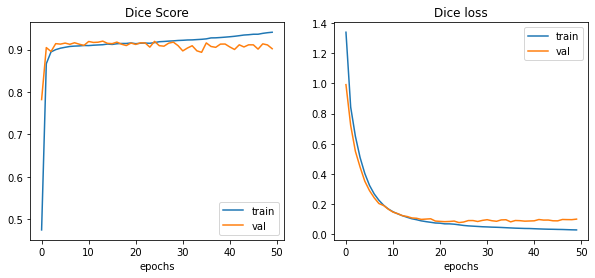

In [23]:
accuracy = metric_history['train']
val_accuracy = metric_history['val'] 

loss = loss_history['train'] 
val_loss = loss_history['val']

epochs = range(len(loss_history['train']))

fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="train") 
plt.plot(epochs, val_accuracy, label="val")
plt.xlabel('epochs')
plt.legend() 
plt.title('Dice Score') 

plt.subplot(1, 2, 2)
# plt.figure()
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="val") 
plt.xlabel('epochs')
plt.legend() 
plt.title('Dice loss')

## Test

In [24]:
# 시각화를 위한 RGB값

mask_rgb = {
    0: [0, 0, 0],
    1: [255, 0, 0],
    2: [0, 255, 0],
    3: [0, 0, 255],
    4: [255, 255, 0],
    5: [0, 255, 255],
    6: [255, 0, 255],
    7: [208, 200, 187],
    8: [93, 93, 195],
    9: [207, 171, 136],
    10: [221, 206, 186],
    11: [51, 204, 204]
}

In [25]:
def gray_to_rgb(gray_image):
    rgb_img = np.zeros((512, 512, 3))
    
    for layer, rgb_value in mask_rgb.items():
        class_region = gray_image == layer
        rgb_img[class_region.cpu()] = rgb_value
        
    return rgb_img

In [29]:
filename = "best_loss_25.pth"
checkpoint_path = f"/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/checkpoints/train(JHL_newsplit_curation_v2)/{filename}" 
net.load_state_dict(torch.load(checkpoint_path))
net.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [27]:
# 결과 이미지 저장 폴더 생성
os.mkdir(f'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/test_results/train(JHL_newsplit_curation)')
save_path = '/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/test_results/train(JHL_newsplit_curation)'

In [ ]:
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(1,2,0)
# net.eval()
test_loss = 0.0
test_dice_score = 0.0
dice_score_per_layer = {}
num_test_batches = len(test_dataloader)

with torch.no_grad():
    
    for idx, batch in enumerate(test_dataloader):
        
        images = batch['image']
        targets = batch['mask']
        
        name = batch['filename']
    
        last_name = name[0].split('/')[-1]
        patient = last_name.split('_')[0]
        lateral = last_name.split('_')[1]
        img_num_png = last_name.split('_')[2]
        img_num = re.split('[.]+', img_num_png)[0]

        images = images.to(device=device, dtype=torch.float32)
        targets = targets.to(device=device, dtype=torch.long)

        masks_pred = net(images)

        loss = criterion(masks_pred, targets)

        test_loss += loss
        
        masks_pred = masks_pred.argmax(dim=1)
        
        # for image, target, pred_array in zip(images, targets, masks_pred):
        # print(targets.squeeze().shape)
        target_img = gray_to_rgb(targets.squeeze())
        pred_img = gray_to_rgb(masks_pred.squeeze())

        #결과 이미지 저장
        imgs = np.hstack((target_img, pred_img))
        # print(imgs.shape)
        plt.imshow(imgs.astype('uint8'))
        # print(f'{save_path}/{patient}_{lateral}_{img_num}')
        print(patient)
        print(img_num)
        # plt.imsave(os.path.join(save_path, '%s_%s_%s.png' % (patient, lateral, img_num)), imgs.astype('uint8'))

        # destination = f'{save_path}'
        # save = shutil.copy2(imgs, f"{destination}/{patient}_{lateral}_{img_num}")

        fig = plt.figure(figsize=(20, 20)) 

        print(images.squeeze(0).shape)
        print(target_img.shape)
        
        plt.subplot(1, 3, 1)
        plt.imshow(fn_tonumpy(images.cpu().squeeze(0)), cmap = plt.cm.gray)

        plt.subplot(1, 3, 2)
        plt.imshow(target_img.astype('uint8'))

        plt.subplot(1, 3, 3)
        plt.imshow(pred_img.astype('uint8'))

        plt.tight_layout()
        plt.show()

        targets = F.one_hot(targets, net.n_classes).permute(0, 3, 1, 2).float()
        masks_pred = F.one_hot(masks_pred, net.n_classes).permute(0, 3, 1, 2).float()

        dice_score, dice_score_list = multiclass_dice_coeff(masks_pred[:, 1:, ...], targets[:, 1:, ...], reduce_batch_first=False)
        test_dice_score += dice_score

        for idx, dice_score in enumerate(dice_score_list):
            if dice_score_per_layer.get(idx + 1) == None:
                dice_score_per_layer[idx + 1] = dice_score.item()
            else:
                dice_score_per_layer[idx + 1] += dice_score.item()
                
avg_test_loss = test_loss / num_test_batches
avg_test_score = test_dice_score / num_test_batches
test_dice_score_per_layer = {layer: round(dice_score / num_test_batches, 3) for layer, dice_score in dice_score_per_layer.items()}

print(f'test loss: {avg_test_loss:.3f} \ntest dice_score: {avg_test_score:.3f} \ntest_dice_score_per_layer: {json.dumps(test_dice_score_per_layer, sort_keys=False, indent=4)}')

writer.add_scalar('Loss/test', avg_test_loss, epoch)
writer.add_scalar('Dice_Score/test', avg_test_score, epoch)

writer.flush()

In [37]:
imgs.shape

(512, 1024, 3)